In [1]:
using Turing, Gadfly, Reactive, Interact
using Turing: invlogit
sigmoid(x) = invlogit(x)

INFO: Recompiling stale cache file /Users/kai/.julia/lib/v0.5/Rmath.ji for module Rmath.
INFO: Recompiling stale cache file /Users/kai/.julia/lib/v0.5/StatsFuns.ji for module StatsFuns.
INFO: Recompiling stale cache file /Users/kai/.julia/lib/v0.5/PDMats.ji for module PDMats.
INFO: Recompiling stale cache file /Users/kai/.julia/lib/v0.5/Distributions.ji for module Distributions.
INFO: Recompiling stale cache file /Users/kai/.julia/lib/v0.5/Calculus.ji for module Calculus.
INFO: Recompiling stale cache file /Users/kai/.julia/lib/v0.5/ForwardDiff.ji for module ForwardDiff.
INFO: Recompiling stale cache file /Users/kai/.julia/lib/v0.5/UnicodePlots.ji for module UnicodePlots.
INFO: Recompiling stale cache file /Users/kai/.julia/lib/v0.5/ProgressMeter.ji for module ProgressMeter.


sigmoid (generic function with 1 method)

In [11]:
# nn_forward(x, W₁, b₁, wₒ, bₒ) = begin
#     h₁ = tanh(W₁' * x + b₁)
#     sigmoid(wₒ' * h₁ + bₒ)
# end

nn_forward(x, W₁, b₁, W₂, b₂, wₒ, bₒ) = begin
    h₁ = tanh(W₁' * x + b₁)
    h₂ = tanh(W₂' * h₁ + b₂)
    sigmoid(wₒ' * h₂ + bₒ)
end

na2mat(na) = begin
    ncol = length(na); nrow = length(na[1])
    mat = Matrix{eltype(na[1])}(nrow, ncol)
    for n = 1:ncol mat[:, n] = na[n] end
    mat
end

# nn_predict(x, W₁, b₁, Wₒ, bₒ) = begin
#     mean([nn_forward(x, W₁[i], b₁[i], wₒ[i], bₒ[i])[1] for i in 1:length(bₒ)])
# end

nn_predict(x, W₁, b₁, W₂, b₂, Wₒ, bₒ, n_end) = begin
    mean([nn_forward(x, W₁[i], b₁[i], W₂[i], b₂[i], wₒ[i], bₒ[i])[1] for i in 1:10:n_end])
end

nn_predict (generic function with 1 method)

In [63]:
N = 100; M = round(Int, N / 4)
x1s = rand(M) * 5; x2s = rand(M) * 5
xt1s = Array([[x1s[i]; x2s[i]] for i = 1:M])
x1s = rand(M) * 5; x2s = rand(M) * 5
append!(xt1s, Array([[x1s[i] - 6; x2s[i] - 6] for i = 1:M]))
x1s = rand(M) * 5; x2s = rand(M) * 5
xt0s = Array([[x1s[i]; x2s[i] - 6] for i = 1:M])
x1s = rand(M) * 5; x2s = rand(M) * 5
append!(xt0s, Array([[x1s[i] - 6; x2s[i]] for i = 1:M]))

xs = [xt1s; xt0s];
ts = [ones(2*M); zeros(2*M)];

# Plot data points
d1_layer = layer(x=map(e -> e[1], xt1s), y=map(e -> e[2], xt1s), Geom.point, Theme(default_color=colorant"royalblue"))
d2_layer = layer(x=map(e -> e[1], xt0s), y=map(e -> e[2], xt0s), Geom.point, Theme(default_color=colorant"springgreen"))

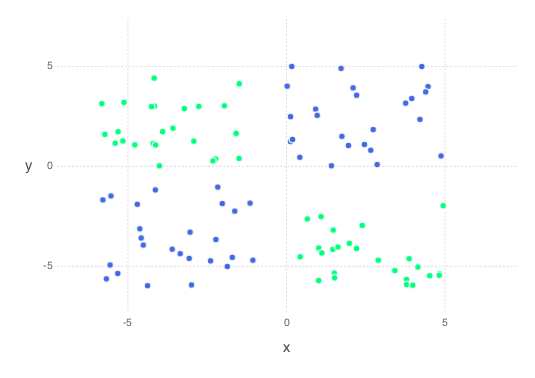

In [64]:
plot(d1_layer, d2_layer, Coord.Cartesian(xmin=-7, xmax=7, ymin=-7, ymax=7))

In [65]:
alpha = 0.16            # regularizatin term
var = sqrt(1.0 / alpha) # variance of the Gaussian prior
N_in = 2; N_h = [3, 2]
@model bayes_nn(xs, ts) = begin
    W₁ = Matrix{Real}(N_in, N_h[1])
    W₁ ~ [MvNormal(zeros(N_in), var * ones(N_in))]
    b₁ ~ MvNormal(zeros(N_h[1]), var * ones(N_h[1]))

    W₂ = Matrix{Real}(N_h[1], N_h[2])
    W₂ ~ [MvNormal(zeros(N_h[1]), var * ones(N_h[1]))]
    b₂ ~ MvNormal(zeros(N_h[2]), var * ones(N_h[2]))

    wₒ ~ MvNormal(zeros(N_h[end]), var * ones(N_h[end]))
    bₒ ~ Normal(0, var)
    
    for i = 1:length(ts)
        ts[i] ~ Bernoulli(nn_forward(xs[i], W₁, b₁, W₂, b₂, wₒ, bₒ)[1])
    end
end

bayes_nn (generic function with 3 methods)

In [66]:
N = 1000
ch = sample(bayes_nn(xs, ts), HMC(N, 0.05, 5));

[Turing]:  Assume - `W₁` is a parameter (ignoring `W₁` found in global scope)
  in @~(::Any, ::Any) at compiler.jl:49
[Turing]:  Assume - `b₁` is a parameter (ignoring `b₁` found in global scope)
  in @~(::Any, ::Any) at compiler.jl:49
[Turing]:  Assume - `W₂` is a parameter (ignoring `W₂` found in global scope)
  in @~(::Any, ::Any) at compiler.jl:49
[Turing]:  Assume - `b₂` is a parameter (ignoring `b₂` found in global scope)
  in @~(::Any, ::Any) at compiler.jl:49
[Turing]:  Assume - `wₒ` is a parameter (ignoring `wₒ` found in global scope)
  in @~(::Any, ::Any) at compiler.jl:49
[Turing]:  Assume - `bₒ` is a parameter (ignoring `bₒ` found in global scope)
  in @~(::Any, ::Any) at compiler.jl:49
[Turing]:  Observe - `ts` is an observation
  in @~(::Any, ::Any) at compiler.jl:28


[HMC] Sampling... 44%  ETA: 0:00:13

[HMC] Finished with
  Running time        = 22.516466809000022;
  Accept rate         = 0.451;
  #lf / sample        = 4.995;
  #evals / sample     = 4.997;
  pre-cond. diag mat  = [1.0,1.0,1.0,1.0,1.0,1.0,1.0,1....


[HMC] Sampling...100% Time: 0:00:23


In [67]:
b₁ = ch[:b₁]; W₁ = map(na->na2mat(na), ch[:W₁]);
b₂ = ch[:b₂]; W₂ = map(na->na2mat(na), ch[:W₂]);
bₒ = ch[:bₒ]; wₒ = ch[:wₒ];

Interact.Options{:SelectionSlider,Int64}(81: "input-21" = 550 Int64 ,"n_end",550,"550",Interact.OptionDict(DataStructures.OrderedDict("100"=>100,"110"=>110,"120"=>120,"130"=>130,"140"=>140,"150"=>150,"160"=>160,"170"=>170,"180"=>180,"190"=>190…),Dict(830=>"830",990=>"990",210=>"210",520=>"520",370=>"370",360=>"360",530=>"530",940=>"940",160=>"160",170=>"170"…)),Any[],Any[],true,"horizontal")

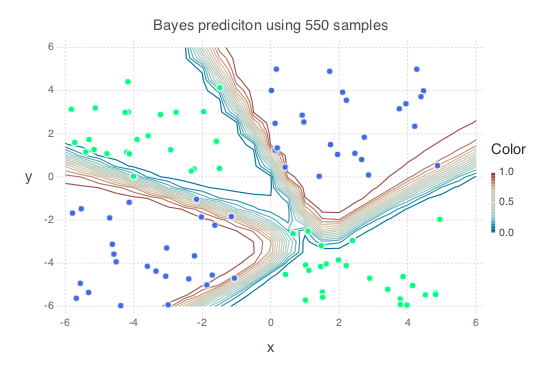

In [68]:
@manipulate for n_end = 100:10:N
    p_layer = layer(z=(x,y) -> nn_predict([x, y], W₁, b₁, W₂, b₂, wₒ, bₒ, n_end), 
                    x=linspace(-6,6,25), y=linspace(-6,6,25), Geom.contour)
    plot(d1_layer, d2_layer, p_layer, 
         Coord.cartesian(xmin=-6, xmax=6, ymin=-6, ymax=6),
         Guide.title("Bayes prediciton using $n_end samples"))
end